In [ ]:
# First cell - Import dependencies
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt


In [ ]:
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/CompVisProject/dataset.zip -d /content/dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_1.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_2.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_3.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_4.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_5.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_6.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_7.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_8.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_9.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_037_aug_1.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_037_aug_2.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_037_aug_3.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_037_aug_4.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_037_aug_5.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_037_aug_6.jpg  
  inflating: /content/dataset/Aldo

In [ ]:
# Second cell - Define model architecture
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2


def create_sign_language_model(num_classes):
    """Creates a MobileNetV2-based model for sign language recognition"""

    # Add an Input layer to define the input shape
    input_tensor = layers.Input(shape=(224, 224, 3))

    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_tensor=input_tensor  # Pass the input tensor to MobileNetV2
    )

    base_model.trainable = False

    # Build the rest of the model using the Functional API
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x) # Now GlobalAveragePooling2D has a defined input
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    output_tensor = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_tensor, outputs=output_tensor)

    return model

In [ ]:
# Third cell - Create data generator
def create_data_generator(data_dir, batch_size=32, validation_split=0.2):
    """Creates a memory-efficient data generator"""
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        validation_split=validation_split
    )

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    validation_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=True
    )

    return train_generator, validation_generator

In [ ]:
# Fourth cell - Set up data generators
# Update this path to match your Google Drive structure
DATA_DIR = "/content/dataset/Aldos Pics"
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

print("Creating data generators...")
train_generator, validation_generator = create_data_generator(
    DATA_DIR,
    BATCH_SIZE,
    VALIDATION_SPLIT
)

NUM_CLASSES = len(train_generator.class_indices)
print(f"Found {NUM_CLASSES} classes")
print("Class mapping:", train_generator.class_indices)

Creating data generators...
Found 17202 images belonging to 24 classes.
Found 4299 images belonging to 24 classes.
Found 24 classes
Class mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}


In [ ]:
# Fifth cell - Create and compile model
model = create_sign_language_model(NUM_CLASSES)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

<ipython-input-7-9546a3df8354>:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,425,048 (9.25 MB)

 Trainable params: 167,064 (652.59 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Sixth cell - Training
# Sixth cell - Training
EPOCHS = 15

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2
    ),
    tf.keras.callbacks.ModelCheckpoint(
        '/content/best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

# Remove the workers and use_multiprocessing arguments
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


538/538 ━━━━━━━━━━━━━━━━━━━━ 268s 472ms/step - accuracy: 0.6655 - loss: 1.1224 - val_accuracy: 0.9428 - val_loss: 0.2156 - learning_rate: 0.0010
Epoch 2/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 238s 438ms/step - accuracy: 0.9615 - loss: 0.1386 - val_accuracy: 0.9656 - val_loss: 0.1202 - learning_rate: 0.0010
Epoch 3/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 243s 448ms/step - accuracy: 0.9772 - loss: 0.0817 - val_accuracy: 0.9637 - val_loss: 0.1124 - learning_rate: 0.0010
Epoch 4/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 235s 432ms/step - accuracy: 0.9815 - loss: 0.0625 - val_accuracy: 0.9686 - val_loss: 0.0943 - learning_rate: 0.0010
Epoch 5/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 232s 426ms/step - accuracy: 0.9868 - loss: 0.0436 - val_accuracy: 0.9628 - val_loss: 0.1037 - learning_rate: 0.0010
Epoch 6/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 238s 437ms/step - accuracy: 0.9883 - loss: 0.0380 - val_accuracy: 0.9719 - val_loss: 0.0900 - learning_rate: 0.0010
Epoch 7/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 251s 462ms/step - accuracy: 0.9874 

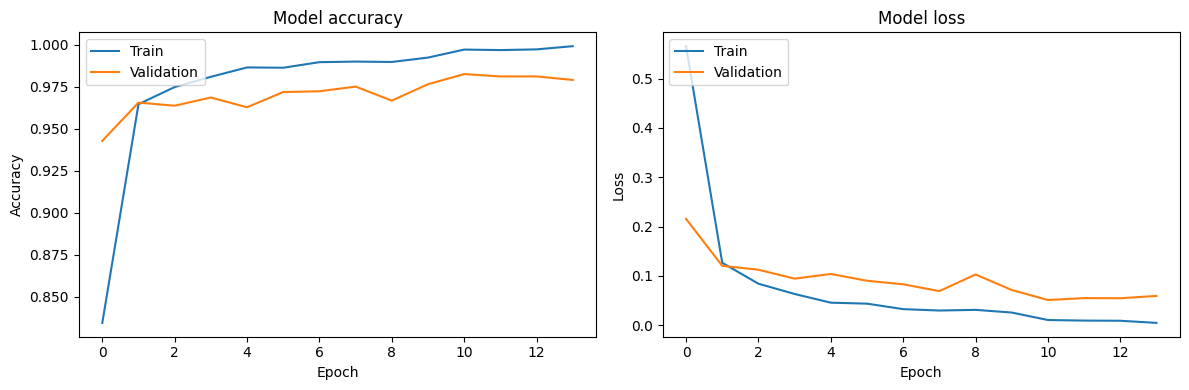

In [ ]:
# Seventh cell - Visualize training results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Eighth cell - Convert and save model
def save_for_inference(model, save_path):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()

    with open(save_path, 'wb') as f:
        f.write(tflite_model)

    print(f"Model saved to {save_path}")

# Save model to Google Drive
model_save_path = "/content/MobileNet.tflite"
save_for_inference(model, model_save_path)

# Save class indices
class_indices = train_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

with open('/content/class_names.txt', 'w') as f:
    for i in range(len(class_names)):
        f.write(f"{class_names[i]}\n")

print("Model and class names saved to Google Drive")

Saved artifact at '/tmp/tmp3tf2qx20'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 24), dtype=tf.float32, name=None)
Captures:
  137119116288144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137119116005568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137119116001520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137119116002928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137119116003104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137119116009264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137119116008736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137119116012608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137119116009968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137119116010848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137119116

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


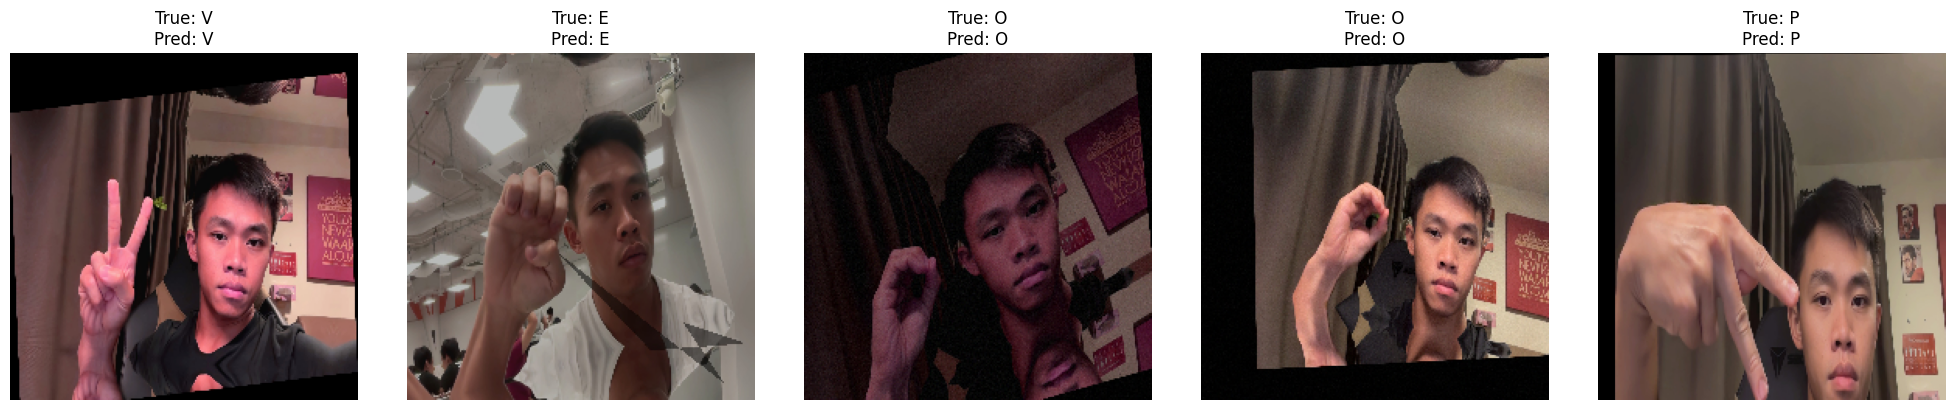

In [ ]:
# Ninth cell (optional) - Test model on a few samples
def test_model_on_samples(model, generator, num_samples=5):
    """Test the model on a few samples from the validation set"""
    # Get a batch of images
    batch_x, batch_y = next(generator)

    # Make predictions
    predictions = model.predict(batch_x[:num_samples])

    # Plot results
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))

    for i in range(num_samples):
        # Display image
        axes[i].imshow(batch_x[i])

        # Get true and predicted classes
        true_class = np.argmax(batch_y[i])
        pred_class = np.argmax(predictions[i])

        # Get class names
        true_name = class_names[true_class]
        pred_name = class_names[pred_class]

        # Set title
        axes[i].set_title(f'True: {true_name}\nPred: {pred_name}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on a few samples
test_model_on_samples(model, validation_generator)